## 4.10 Predicting House Prices on Kaggle
### 4.10.1 Datasets

In [3]:
import os,requests,zipfile,tarfile,hashlib
DATA_HUB=dict()
DATA_URL="http://d2l-data.s3-accelerate.amazonaws.com/"

In [4]:
def download(name, cache_dir=os.path.join('data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash =DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname=os.path.join(cache_dir,url.split('/')[-1])
    if os.path.exists(fname):
        sha1=hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data=f.read(1048576)
                if not data: break
                sha1.update(data)
        if sha1.hexdigest()==sha1_hash: return fname
    print(f'Downloading {fname} from {url}...')
    r=requests.get(url, stream=True, verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname

In [5]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname=download(name)
    base_dir=os.path.dirname(fname)
    data_dir, ext=os.path.splitext(fname)
    if ext=='.zip': fp=zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'): fp=tarfile.open(fname,'r')
    else: assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

In [6]:
def download_all():
    """Download all files in the DATA_HUB"""
    for name in DATA_HUB: download(name)

### 4.10.2 Kaggle

In [26]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import gluon, autograd, init, np, npx
from mxnet.gluon import nn
from tools import show_subtitle
import pandas as pd
npx.set_np()

In [10]:
DATA_HUB['kaggle_house_train']=(DATA_URL+'kaggle_house_pred_train.csv','585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test']=(DATA_URL+'kaggle_house_pred_test.csv','fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [11]:
train_data=pd.read_csv(download('kaggle_house_train'))
test_data=pd.read_csv(download('kaggle_house_test'))

In [12]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [13]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [14]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [16]:
# 4.10.4 Data Preprocessing
# 提取出 36 个数值特征的索引，然后对这些数值特征进行均值化处理
numeric_features=all_features.dtypes[all_features.dtypes !='object'].index
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
# After standarding the data all means vanish, hence we can set missing values to 0
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [17]:
# 'Dummy_na=True' considers 'na'(missing value) as a valid feature value, and creates and indicator feature for it
# 将缺失值也作为一个特征
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [18]:
n_train=train_data.shape[0]
train_features=np.array(all_features[:n_train].values, dtype=np.float32)
test_features=np.array(all_features[n_train:].values,dtype=np.float32)
train_labels=np.array(train_data.SalePrice.values.reshape(-1,1),dtype=np.float32)

In [19]:
# 4.10.5 Training
loss=gluon.loss.L2Loss()
def get_net():
    net=nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [20]:
def log_rmse(net,features,labels):
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1
    clipped_preds=np.clip(net(features), 1, float('inf'))
    return np.sqrt(2*loss(np.log(clipped_preds),np.log(labels)).mean())

In [21]:
def train(net,train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls=[],[]
    train_iter=d2l.load_array((train_features,train_labels),batch_size)
    trainer=gluon.Trainer(net.collect_params(),'adam', 
                            {'learning_rate':learning_rate,'wd':weight_decay})
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l=loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [23]:
# 4.10.6 K-Fold Cross-Validation
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i: X_valid, y_valid=X_part,y_part
        elif X_train is None: X_train,y_train=X_part,y_part
        else:
            X_train=np.concatenate([X_train,X_part],0)
            y_train=np.concatenate([y_train,y_part],0)
    return X_train, y_train, X_valid, y_valid

In [24]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net()
        train_ls, valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0: 
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',
                xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
        print(f'fold{i+1}, train log rmse {float(train_ls[-1]):f}')
        print(f'fold{i+1}, valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum/k, valid_l_sum/k

fold1, train log rmse 0.169516
fold1, valid log rmse 0.156789
fold2, train log rmse 0.162129
fold2, valid log rmse 0.190189
fold3, train log rmse 0.163562
fold3, valid log rmse 0.167782
fold4, train log rmse 0.167827
fold4, valid log rmse 0.154547
fold5, train log rmse 0.162571
fold5, valid log rmse 0.182864
5-fold validation: avg train log rmse: 0.165121
5-fold validation: avg valid log rmse: 0.170434


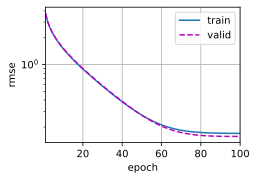

In [25]:
# 4.10.7 Model Selection
k,num_epochs, lr, weight_decay, batch_size=5,100,5,0,64
train_l, valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
show_subtitle(f'{k}-fold validation')
print(f'avg train log rmse: {float(train_l):f}')
print(f'avg valid log rmse: {float(valid_l):f}')

In [28]:
# 4.10.8 Submitting Predictions on Kaggle
def train_and_pred(train_features, test_features, train_labels, test_data, 
                    num_epochs, lr, weight_decay, batch_size):
    net=get_net()
    train_ls, _=train(net,train_features,train_labels,None,None,
                        num_epochs,lr,weight_decay,batch_size)                    
    d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',ylabel='log rmse',
                xlim=[1,num_epochs],yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds=d2l.numpy(net(test_features))
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.csv',index=False)              

train log rmse 0.162881


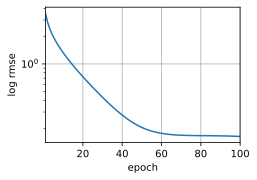

In [29]:
train_and_pred(train_features,test_features,train_labels,test_data,
                num_epochs,lr,weight_decay,batch_size)